In [1]:
import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
import os
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
from IPython.display import clear_output, display
import librosa
import math
import datetime
import time
import numpy as np
import tqdm
import random

#Eigene Sachen
from train import train_model
from data.data import *
from util.util import *
from util.datasets import *
from util.audio_processing import *
import util.plot as plot
import models

c:\Program Files\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Program Files\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Program Files\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#%%timeit
#for i in np.random.randint(0, len(filedataset_train), size=1000):
#    waveform, sr, _ = filedataset_train[i]

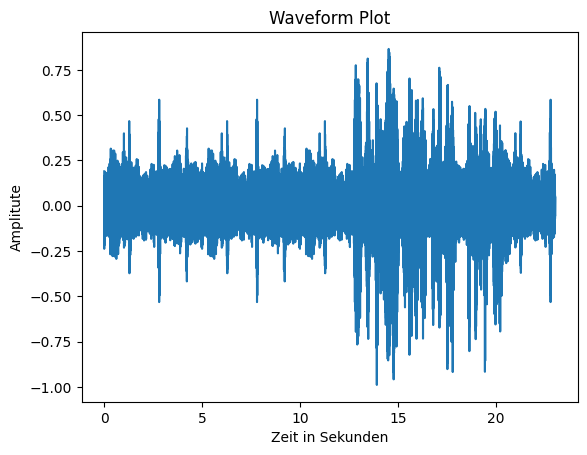

In [5]:
#PLOT
plot_idx = 1233
tensor, sr, _ = filedataset_train[plot_idx]
plot.plot_waveform(tensor, sr)

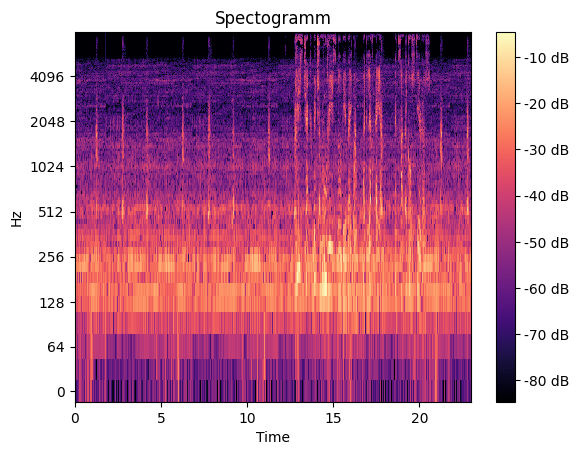

In [2]:
plot_idx = 1233
tensor, sr, _ = filedataset_train[plot_idx]
plot.plot_spectorgram(tensor, sr, SAMPLE_LENGTH, HOP_LENGTH)

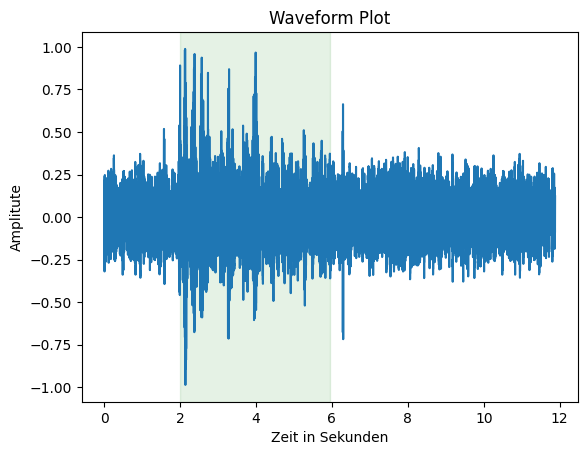

In [3]:
plot_idx = 53
tensor, sr, info = filedataset_train[plot_idx]
plot.plot_waveform_with_voice(tensor, get_y(tensor, sr, info), sr=sr)

Text(0.5, 1.0, 'Samples Plot')

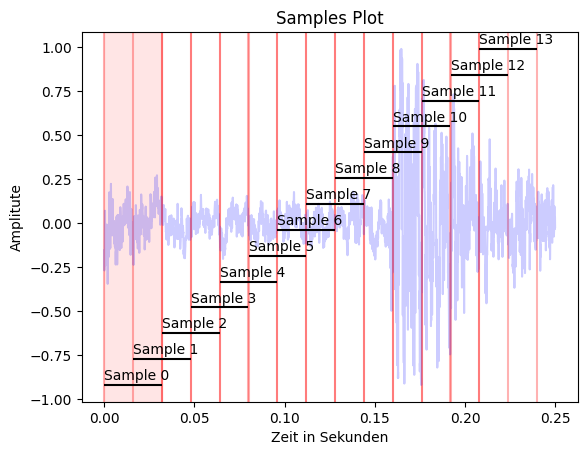

In [4]:
#BSP-Plot
plot_length = 0.25

plot_idx = 51
tensor, sr, _ = filedataset_train[plot_idx]

#x-Achse
time_axis = torch.arange(0,librosa.time_to_samples(plot_length,sr=SAMPLE_RATE)) / sr
time_axis.numpy()

#y-Achse
y = tensor[:time_axis.shape[-1]].numpy()

#Plottet Waveform
plt.plot(time_axis,y, color="blue", alpha=0.2)

#Plottet Samples
plot_data = get_samples(time_axis,SAMPLE_LENGTH, HOP_LENGTH)

y_max     = y.max()
y_min     = y.min()
n_samples = plot_data.shape[0]

for idx, sample in enumerate(plot_data):

    #Start und Ende
    start = sample[0]
    end   = sample[-1]
    
    #Plottet horizontale  Rote Linie
    plt.axvline(start, color="red", alpha=0.3, zorder = 1)
    plt.axvline(end,   color="red", alpha=0.3, zorder = 1)

    #Plottet schwarzen Strich mit Label Sample X
    sample_line_hight = y_min + abs(y_max - y_min) * idx / (n_samples - 1)
    plt.hlines(sample_line_hight, start, end, color="black")
    plt.annotate(f"Sample {idx}",(start, sample_line_hight), textcoords="offset pixels", xytext=(0,5))

    #plottet für ersen Idx noch den Hintergrund
    if idx == 0:
        plt.axvspan(xmin = start, xmax = end, alpha=0.1,color="red", label="Sample Länge")

plt.xlabel("Zeit in Sekunden")
plt.ylabel("Amplitute")
plt.title("Samples Plot")

None

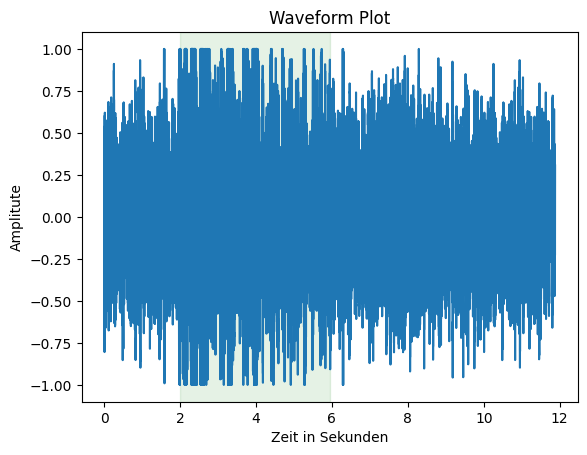

In [6]:
plot_idx = 53
tensor, sr, info = filedataset_train[plot_idx]

#Beispiel Hardclipper
hardclipper = RandomGain(6,12)
out_hardclipper = hardclipper(tensor)

#Out
display(Audio(out_hardclipper,rate=SAMPLE_RATE))
display(plot.plot_waveform_with_voice(out_hardclipper, get_y(tensor, sr, info), sr))

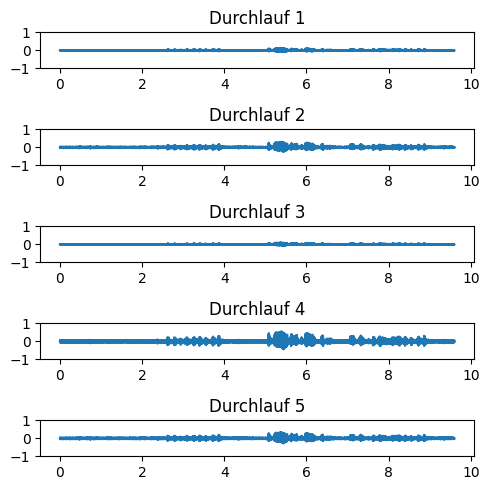

In [7]:
#Plot
_num_plots = 5
_plot_idx  = 0

fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):

    #Lädt Daten in unterschiedlichler Lautstärke
    x, y = speakdataset_train_unchunked[_plot_idx]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_waveform(x, sr = SAMPLE_RATE, ax=ax, y_axis_0dbfs_scale=True)
    ax.set_title(f"Durchlauf {i + 1}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()

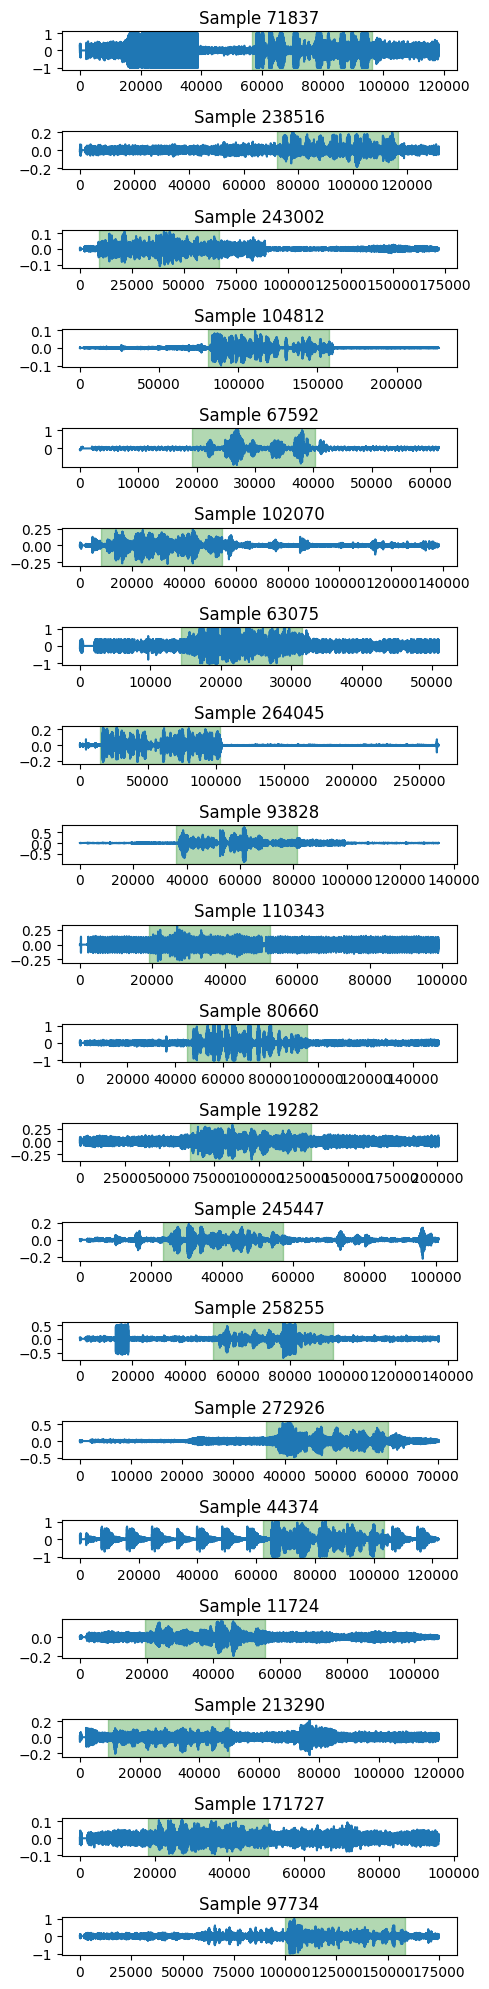

In [2]:
_num_plots = 20

#Plot
fig = plt.figure(figsize=(5,_num_plots))

#Iterriert
for i in range(_num_plots):
    
    #Lädt random Sample
    random_idx = np.random.randint(0, len(dataset_train))
    x, y, = dataset_train[ random_idx ]

    #Plottet
    ax = plt.subplot2grid((_num_plots, 1), (i, 0), fig=fig)
    plot.plot_model_prediction(x=x, y=y, sample_length = SAMPLE_LENGTH, hop_length=HOP_LENGTH, context_length = CONTEXT_LENGTH, ax=ax)

    ax.set_title(f"Sample {random_idx}")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()


Erstelle Plot: IDX : '0' | X : '0' | Y : '0'
Erstelle Plot: IDX : '1' | X : '1' | Y : '0'
Erstelle Plot: IDX : '2' | X : '2' | Y : '0'
Erstelle Plot: IDX : '3' | X : '3' | Y : '0'


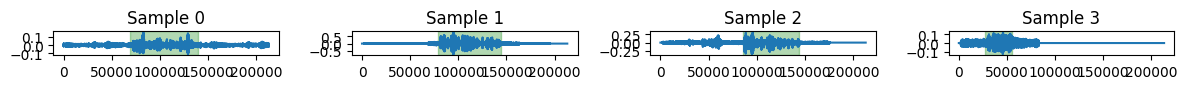

In [3]:
#Test
x, y = next(iter(dataloader_train))
plot.plot_batch(x, y, SAMPLE_LENGTH, HOP_LENGTH, CONTEXT_LENGTH)

100%|██████████| 10/10 [01:11<00:00,  7.10s/it]


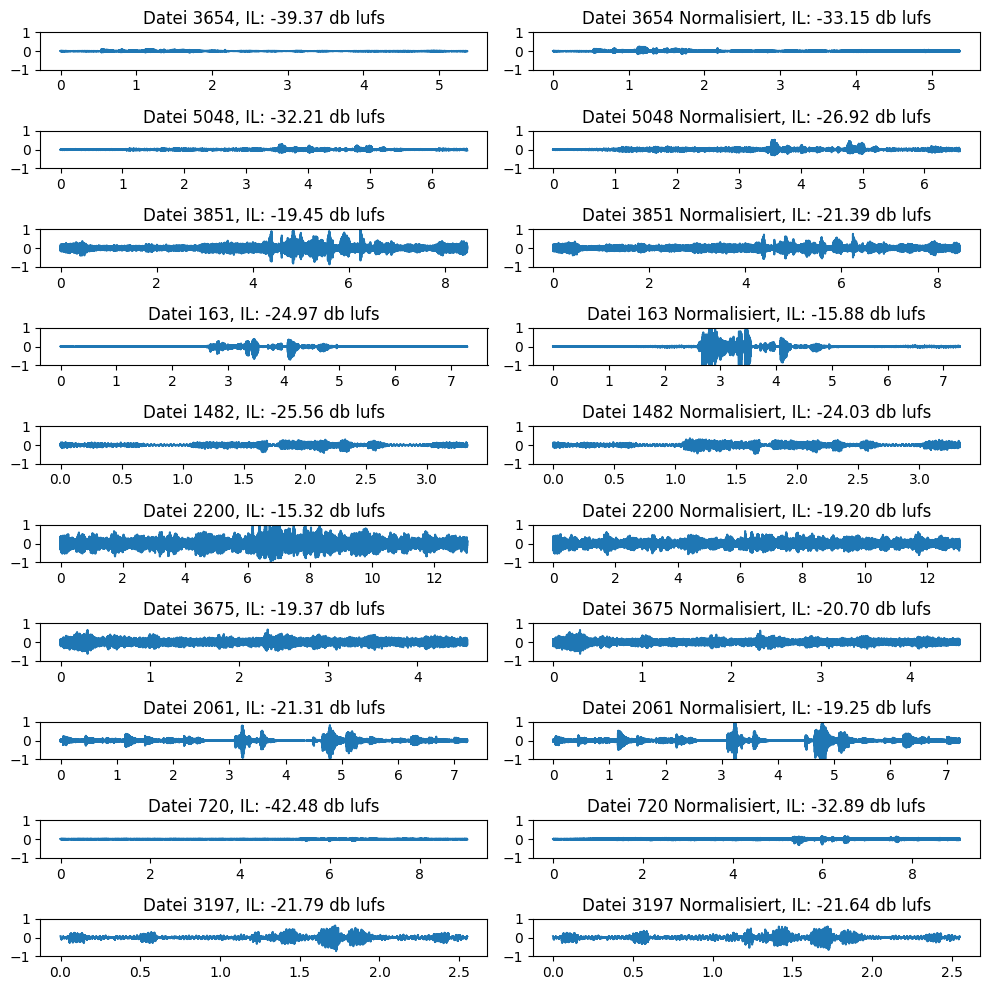

In [2]:
#Plot
_num_plots = 10

#Figure
fig = plt.figure(figsize=(5 * 2, _num_plots))

#Meter
meter = torchaudio.transforms.Loudness(SAMPLE_RATE)

#FFLC
fflc = FeedForwardLoudnessControll(sample_rate=SAMPLE_RATE, hop_length=HOP_LENGTH)

#Iterriert
for i in tqdm.tqdm(range(_num_plots)):
    
    #Lädt Daten in unterschiedlichler Lautstärke
    idx = random.randint(0, len(speakdataset_test_unchunked))
    x, y = speakdataset_test_unchunked[ idx ]

    #Plottet Unnormalisiert
    ax = plt.subplot2grid((_num_plots, 2), (i, 0), fig=fig)
    plot.plot_waveform(x, sr = SAMPLE_RATE, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Datei {idx}, IL: {meter(x.unsqueeze(0)):.2f} db lufs")
    ax.set_xlabel("")
    ax.set_ylabel("")

    #Plottet Normalisiert
    normalized_x = fflc(x)
    ax = plt.subplot2grid((_num_plots, 2), (i, 1), fig=fig)
    plot.plot_waveform(normalized_x, sr = SAMPLE_RATE, ax=ax, y_axis_0dbfs_scale=True)

    ax.set_title(f"Datei {idx} Normalisiert, IL: {meter(normalized_x.unsqueeze(0)):.2f} db lufs")
    ax.set_xlabel("")
    ax.set_ylabel("")

#Plot
fig.tight_layout()

In [56]:
#Imports
import torchmetrics

#Accuracy
accuracy = torchmetrics.classification.BinaryAccuracy()

#Erstellt eigenes ChunkedDataset für Test
speak_test_dataset = ChunkedDataset(speak_test_dataset_unchunked, SAMPLE_LENGTH, SAMPLE_LENGTH, False)

#Ergebnis
pred_total = []
y_total    = []

#Iterriert über Sample
with torch.no_grad():
        
        #Iterriert Samples
        for x, y, idx in iter(speak_test_dataset):

                #Prediction
                pred = torch.zeros_like(y)

                #Iterriert Samples
                for pos, chunk in enumerate(x):
                        
                        start_pos = pos * chunk.size(-1)
                        end_pos   = start_pos + chunk.size(-1)
                        pred[start_pos : end_pos] = model(chunk).item()
                
                #Fügt Total an
                pred_total.append(pred)
                y_total.append(y)

#Tensor
y_total    = torch.hstack(y_total)
pred_total = torch.hstack(pred_total)

#Print für Accuracy
print("Accuracy auf Batch:", accuracy(pred_total, y_total))

Accuracy auf Batch: tensor(0.7535)


In [ ]:
#Plot
_tresh = -10

#Data
x,y,n = speak_train_dataset[100]


comp = Compressor(treshold=_tresh, ratio=2)
x_comp = comp(x)

waveform_original = reverse_unfold(x)
waveform_comp     = reverse_unfold(x_comp).detach()

plt.plot(waveform_original, color="blue", label="Original")
plt.plot(waveform_comp,     color="orange", label="Komprimiert")
plt.axhline(y= db_to_amp(_tresh), color="red")
plt.axhline(y= db_to_amp(_tresh) * -1, color="red")
plt.legend()
plt.title("Compressor")